# ISMI2018 Lymphocyte Detection Project
This is the main notebook for the final ISMI2018 project by Group 6.


*Detection of lymphocytes in histopathology whole-slide images of breast, colon and prostate cancer, stained with immunohistochemistry*

### Team 6
Our group consists out of four people:
* **Brian Westerweel (Data Science)** - `B.Westerweel@student.ru.nl`
* **Christoph Schmidl (Data Science)** - `c.schmidl@student.ru.nl`
* **Gijs van der Meijde (Software Science)** - `G.vanderMeijde@student.ru.nl`
* **Jeffrey Luppus (Data Science)** - `J.Luppes@student.ru.nl`

*Supervisor: Francesco Ciompi*

Group Github page: https://github.com/jeffluppes/ISMI2018 *feel free to work in branches.*

## Goals for this week (May 28 to June 3)

GOALS
* ~~PREDICT AND PLOT PREDICTIONS: JEFFREY~~
* PRESENTATION: ??
* PATCHES V.2 (GIJS)

Main goals:
* The Photoshop gig: Figure out open source tools to manually annotate images 
* ~~Figure out good loss (dice?) / metric >> Talk with Francesco about it~~
* ~~Store model weights, load model weights~~
* ~~Implement sanity checks to view images through the process~~
* ~~normalize images~~
* Prepare presentation for next week (see skeleton I made)


Backlog and minor TODOs

* Implement early stopping 
* Manually annotate 50-60 images 
* Add documentation text above each significant cell
* probabilities to centers to -> csv 
* he_normal kernel initializer?
* Plot loss throughout epochs
* Use validation set to predict
* Vizualize predictions on test set 
* figure out a way to split images into patches, then stitch them back together at the end.. or can we just predict on full images? (split merge vs full) We do not use fully connected layers so I believe we can ( havent tried..)
* Basically, how are we going to validate?
* Expiriment with 1024 at the bottom of the canyon of the U-net
* Save images
* Implement more image deformations? see: https://github.com/cxcxcxcx/imgwarp-opencv


Be aware of the following:

* **Next contact moment**: Monday at 10 skype call > New moment to be scheduled
* **Next group meeting**: Friday and Monday


## Important Deadlines

* <font color='red'>**Mid-term presentation:** June 4, 9:00 - 12:00, room 616 Huygen building</font>
* **Final presentation:** July 2, 9:00 - 12:00, room 616 Huygen building

## Presentation Skeleton-y draft
12 sheets will be good enough I reckon?  

1. Introduction / Opening slide. Our names
2. Open with a joke. Introduce assignment
3. Introduce assignment 2: more in-depth info
4. Show images and annotations as they are
5. Our approach: outline
6. Mask creation
7. Data Augmentation
8. U-net explanation
9. U-net implementation
10. Results so far
11. Our plans for the rest of the course
12. Questions

Please think about this!

## Resources
The two papers Francesco sent:

* https://openreview.net/pdf?id=rk0xLisiM
* https://openreview.net/pdf?id=S10IfW2oz

Kaggle Contest about cell detection (Data Science Bowl 2018)

* https://www.kaggle.com/c/data-science-bowl-2018

Particular Kernels of Interest (KoIs)

* https://www.kaggle.com/weiji14/yet-another-keras-u-net-data-augmentation
* https://www.kaggle.com/piotrczapla/tensorflow-u-net-starter-lb-0-34
* https://www.kaggle.com/keegil/keras-u-net-starter-lb-0-277?scriptVersionId=2164855

Other resources

* https://spark-in.me/post/unet-adventures-part-one-getting-acquainted-with-unet
* https://towardsdatascience.com/medical-image-segmentation-part-1-unet-convolutional-networks-with-interactive-code-70f0f17f46c6 (Christoph)
* https://colab.research.google.com/drive/1BgCDxVdVc0MAe_kC0waMGUV9ShcWW0hM (Christoph)
* https://keunwoochoi.wordpress.com/2017/10/11/u-net-on-keras-2-0/ (Jeff)
* https://github.com/jocicmarko/ultrasound-nerve-segmentation (Jeff)
* https://lmb.informatik.uni-freiburg.de/people/ronneber/u-net/ (Gijs)

### MOOCs if you have spare time to waste (I havent)
http://course.fast.ai/part2.html

http://course.fast.ai/lessons/lesson14.html

In [1]:
# System
from os.path import join, basename, dirname, exists  
import os  
from glob import glob
import csv
import random 
from tqdm import tqdm
from PIL import Image
Image.MAX_IMAGE_PIXELS = 2201136600 #because Pillow will whine to no end if you feed it big images. You're welcome.


# Computational
import pandas as pd  
import numpy as np  
from matplotlib import pyplot as plt  

# Keras
import keras
from keras.preprocessing.image import ImageDataGenerator
from keras import backend as K
from keras.models import Input, Model
from keras.layers import Conv2D, MaxPooling2D, Conv2DTranspose, concatenate, Flatten, Dropout, UpSampling2D, core
from keras.callbacks import ModelCheckpoint


# Other
from scipy.ndimage import imread  
from IPython.display import clear_output
from sklearn.metrics import precision_recall_curve

Using TensorFlow backend.


## General introduction
TODO once more of this takes shape we should have some kind of general introduction here where we talk about the sections to come and how they relate to each other. It should be high-level and introductionary. 

In [2]:
user = 'ruc0030' # Jeffrey = True

## Cartesius file paths

In [3]:
train_dir = '/projects/0/ismi2018/FINALPROJECTS/LYMPHOCYTE_DETECTION/train_images'
validation_dir = '/projects/0/ismi2018/FINALPROJECTS/LYMPHOCYTE_DETECTION/validation_images'
test_dir = '/projects/0/ismi2018/FINALPROJECTS/LYMPHOCYTE_DETECTION/test_images'
train_points = '/projects/0/ismi2018/FINALPROJECTS/LYMPHOCYTE_DETECTION/training_annotations.csv'
validation_points = '/projects/0/ismi2018/FINALPROJECTS/LYMPHOCYTE_DETECTION/validation_annotations.csv' #new
data_dir = 'data'
train_masks_dir = data_dir+'/train_masks'
validation_masks_dir = data_dir+'/validation_masks'
results_dir = 'Results'

num_channels = 3  #changing this breaks the entire thing. 

gen_patches = False #Whether or not you want to generate new patches. Keep false to use patches stored on disk
train_patches_dir = data_dir+'/train_patches'
validation_patches_dir = data_dir+'/validation_patches'

## If the jupyter server runs locally

In [4]:
train_dir = 'train_images'
train_masks_dir = 'train_masks'
#train_points = 'training_annotations.csv'

# Part 1 - Housekeeping
This section defines the convenience methods needed for processing the images.

* Creating various masks (used as ground truth)
    * Square Masks
    * Elipse Masks
    * Circular Masks
    * Mask creation
* Creating patches
    * Patch generation
* Data augmentation generator

### 1a. Creating Circle Masks

In [5]:
def split(x):
    return x.split(', ')

def createSquareMask(h, w, center, radius):
    mask = np.zeros((h, w), dtype=bool)
    lb = center[0] - radius
    rb = center[0] + radius
    ub = center[1] - radius
    bb = center[1] + radius
    mask[ub:bb, lb:rb] = True
    return mask

def createElipseMask(h, w, center, radius):
    Y, X = np.ogrid[:h, :w]
    dist_from_center = np.sqrt((X - center[0])**2 + 2*(Y-center[1])**2)

    mask = dist_from_center <= radius
    return mask

def createCircularMask(h, w, center, radius):
    Y, X = np.ogrid[:h, :w]
    dist_from_center = np.sqrt((X - center[0])**2 + (Y-center[1])**2)

    mask = dist_from_center <= radius
    return mask
    

def createMaskForImage(img_dir, image_path, center_csv, mask_dir, mask_fn, radius=6):
    image_name = image_path.split('.png')[0]
    image_id, roi = image_name.split('_ROI_')
    print('Processing {}'.format(image_name))
    
    image = plt.imread(join(img_dir, image_path))
    mask = np.zeros((image.shape[0], image.shape[1]))
    
    pois = []
    with open(center_csv) as file:
        pois = list(map(split, file.readlines()[1:]))
    
    pois = [poi for poi in pois if (poi[0] == image_id and poi[1] == roi)]

    for poi in pois:
        x = int(float(poi[3]))
        y = int(float(poi[4]))
        shape_mask = mask_fn(image.shape[0], image.shape[1], [x, y], radius)
        mask[shape_mask] = 1
        
    mask_image = Image.fromarray(np.uint8(mask*255), 'L')
    mask_image.save(join(mask_dir, image_name + '_mask.png'))
    print('Created a mask for: {}'.format(image_name))
    
    

In [6]:
training_paths = os.listdir(train_dir)
mask_paths = os.listdir(train_masks_dir)
for path in training_paths:
    # Jeff note: locally I've renamed generated elipsismasks _emasks.png and square masks _smask.png
    mask_name = path.split('.png')[0] + '_mask.png'
    if mask_name not in mask_paths:
        createMaskForImage(train_dir, path, train_points, train_masks_dir, createElipseMask)

### 1b. Patch Generator

In [8]:
#This function generates 1 random patch from patch_amount random images.

def generate_patches(img_dir, msk_dir, patch_amount, width, height):
    patches = []
    all_img_paths = os.listdir(img_dir)
    img_paths = random.sample(all_img_paths, patch_amount)
    
    for img_path in img_paths:
        msk_path = img_path.split('.png')[0] + '_mask.png'
        img = imread(join(img_dir,img_path))
        msk = imread(join(msk_dir, msk_path)) # changed june 1 to include params
        msk = np.stack((msk,)*3, 2)

        coord = getCoord(img, img_path, width, height, train_points)
        if(coord != None):
            patch = generate_patch(img,msk,width,height, coord)
            patches.append(patch)
            print("{}: {}  image: {}".format(len(patches), patch[0].shape, msk_path))
            print("{}: {}  mask:  {}".format(len(patches), patch[1].shape, img_path))
    while(len(patches) < patch_amount):
        print("only {} out of {} patches could be generated, recursing now".format(len(patches), patch_amount))
        np.append(patches, generate_patches(img_dir, msk_dir, patch_amount - (len(patches) -1), width, height), axis=0)
    return patches

#This function generates a single random patch from an image.
def generate_patch(img, msk, width, height, coord):
    padHeight = 0 if height < img.shape[1] else height-img.shape[1]
    padWidth  = 0 if width < img.shape[0] else width-img.shape[0]
    if(img.shape[0] < width or img.shape[1] < height):
        print("padding: {}x{}".format(padWidth, padHeight))
    img = np.pad(img, [(0,padWidth), (0, padHeight), (0,0 )], mode='constant')
    msk = np.pad(msk, [(0,padWidth), (0, padHeight), (0,0 )], mode='constant')
    #x = random.randint(0,img.shape[0]-width);
    x = coord[0]
    x1 = x + width
    #y = random.randint(0,img.shape[1]-height);
    y = coord[1]
    y1 = y + height
    if x1 > img.shape[0] or y1 > img.shape[1]:
        print("WARNING x out of bounds ({} > {}) or y out of bounds ({} > {})".format(x1,img.shape[0],y1,img.shape[1]))
    return (np.array(img[x:x1,y:y1,:]), np.array(msk[x:x1,y:y1,:]))

patch_log = []
coord_tries = []
def getCoord(img, img_path, width, height, csv_file):
    img_name = img_path.split('.png')[0]
    img_id, roi = img_name.split('_ROI_')
    pois = []
    
    with open(csv_file) as file:
        pois = list(map(split, file.readlines()[1:]))
    pois = [poi for poi in pois if (poi[0] == img_id)]
    while(len(coord_tries) < len(pois)):
        #for poi in pois:
        p = random.randint(0,len(pois)-1)
        while(p in coord_tries):
            p = random.randint(0,len(pois)-1)
        coord_tries.append(p)
        poi = pois[p]
        x = int(float(poi[3]))
        y = int(float(poi[4]))
        if( (x,y) in patch_log):
            return None
        patch_log.append( (x,y) )
        if(x - (width/2) >= 0 and x + (width/2) <= img.shape[0] and y - (height/2) >= 0 and y + (height/2) <= img.shape[1]):
            return (round(x - (width/2)), round(y - (height/2)))
    #poi = pois[np.random.choice(len(pois))]
    return (0, 0)

In [11]:
patches = generate_patches(train_dir, train_masks_dir, 300, 512, 512)
mask_patches = []
img_patches = []
for patch in patches:
    img_patches.append(np.array(patch[0]))
    mask_patches.append(np.array(patch[1]))
    
#np.asarray(mask_patches)
#np.asarray(img_patches)
print("----------------------------")
print("{} image patches generated.".format(len(img_patches)))
print("{} mask patches generated.".format(len(mask_patches)))
print("img:  {}".format(np.array(img_patches[0]).shape))
print("mask: {}".format(np.array(mask_patches[0]).shape))

/hpc/sw/python-3.5.2/lib/python3.5/site-packages/ipykernel_launcher.py:10: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0.
Use ``matplotlib.pyplot.imread`` instead.
  # Remove the CWD from sys.path while we load stuff.
/hpc/sw/python-3.5.2/lib/python3.5/site-packages/ipykernel_launcher.py:11: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0.
Use ``matplotlib.pyplot.imread`` instead.
  # This is added back by InteractiveShellApp.init_path()


1: (512, 512, 3)  image: T1C03L1A2B1S11R01_ROI_1_mask.png
1: (512, 512, 3)  mask:  T1C03L1A2B1S11R01_ROI_1.png
2: (512, 512, 3)  image: T10-4360_I_AG_CD3_ROI_6_mask.png
2: (512, 512, 3)  mask:  T10-4360_I_AG_CD3_ROI_6.png
3: (512, 512, 3)  image: T1C03L1A2B1S11R01_ROI_8_mask.png
3: (512, 512, 3)  mask:  T1C03L1A2B1S11R01_ROI_8.png
4: (512, 512, 3)  image: 95-22625-I-4_CD8_ROI_7_mask.png
4: (512, 512, 3)  mask:  95-22625-I-4_CD8_ROI_7.png
5: (512, 512, 3)  image: T17-071823_III3_CD8_ROI_3_mask.png
5: (512, 512, 3)  mask:  T17-071823_III3_CD8_ROI_3.png
6: (512, 512, 3)  image: 10_CD8_ROI_8_mask.png
6: (512, 512, 3)  mask:  10_CD8_ROI_8.png
7: (512, 512, 3)  image: 31_CD3_ROI_9_mask.png
7: (512, 512, 3)  mask:  31_CD3_ROI_9.png
8: (512, 512, 3)  image: 3_CD8_ROI_4_mask.png
8: (512, 512, 3)  mask:  3_CD8_ROI_4.png
padding: 72x0
9: (512, 512, 3)  image: 19-CD3_ROI_19_mask.png
9: (512, 512, 3)  mask:  19-CD3_ROI_19.png
10: (512, 512, 3)  image: 96-08919-4_CD8_ROI_3_mask.png
10: (512, 512, 3)

77: (512, 512, 3)  image: T17-071549_III5_CD3_ROI_7_mask.png
77: (512, 512, 3)  mask:  T17-071549_III5_CD3_ROI_7.png
78: (512, 512, 3)  image: 12-CD3_27.11.2014_17.27.31_ROI_8_mask.png
78: (512, 512, 3)  mask:  12-CD3_27.11.2014_17.27.31_ROI_8.png
79: (512, 512, 3)  image: T2C03L1A2B1S11R01_ROI_12_mask.png
79: (512, 512, 3)  mask:  T2C03L1A2B1S11R01_ROI_12.png
padding: 83x0
80: (512, 512, 3)  image: 3_CD8_ROI_8_mask.png
80: (512, 512, 3)  mask:  3_CD8_ROI_8.png
81: (512, 512, 3)  image: T17-071549_III3_CD3_ROI_7_mask.png
81: (512, 512, 3)  mask:  T17-071549_III3_CD3_ROI_7.png
82: (512, 512, 3)  image: 28_CD8_ROI_5_mask.png
82: (512, 512, 3)  mask:  28_CD8_ROI_5.png
83: (512, 512, 3)  image: T17-071827_III2_CD-3_ROI_1_mask.png
83: (512, 512, 3)  mask:  T17-071827_III2_CD-3_ROI_1.png
84: (512, 512, 3)  image: T1C03L1A2B1S11R01_ROI_9_mask.png
84: (512, 512, 3)  mask:  T1C03L1A2B1S11R01_ROI_9.png
85: (512, 512, 3)  image: 4_CD3_ROI_8_mask.png
85: (512, 512, 3)  mask:  4_CD3_ROI_8.png
86: (

154: (512, 512, 3)  image: 28_CD8_ROI_6_mask.png
154: (512, 512, 3)  mask:  28_CD8_ROI_6.png
155: (512, 512, 3)  image: 31_CD3_ROI_10_mask.png
155: (512, 512, 3)  mask:  31_CD3_ROI_10.png
156: (512, 512, 3)  image: T1C02L1A1B1S11R01_ROI_1_mask.png
156: (512, 512, 3)  mask:  T1C02L1A1B1S11R01_ROI_1.png
157: (512, 512, 3)  image: T17-071823_III3_CD8_ROI_8_mask.png
157: (512, 512, 3)  mask:  T17-071823_III3_CD8_ROI_8.png
padding: 49x0
158: (512, 512, 3)  image: 95-00909-II-L1_CD8_ROI_8_mask.png
158: (512, 512, 3)  mask:  95-00909-II-L1_CD8_ROI_8.png
159: (512, 512, 3)  image: 10_CD8_ROI_1_mask.png
159: (512, 512, 3)  mask:  10_CD8_ROI_1.png
160: (512, 512, 3)  image: 37_CD3_ROI_3_mask.png
160: (512, 512, 3)  mask:  37_CD3_ROI_3.png
161: (512, 512, 3)  image: 13_CD8_ROI_9_mask.png
161: (512, 512, 3)  mask:  13_CD8_ROI_9.png
162: (512, 512, 3)  image: 37_CD3_ROI_4_mask.png
162: (512, 512, 3)  mask:  37_CD3_ROI_4.png
163: (512, 512, 3)  image: T3C02L1A1B1S11R01_ROI_8_mask.png
163: (512, 512,

232: (512, 512, 3)  image: T10-4360_I_Y_CD8_ROI_4_mask.png
232: (512, 512, 3)  mask:  T10-4360_I_Y_CD8_ROI_4.png
233: (512, 512, 3)  image: T3C02L1A1B1S11R01_ROI_1_mask.png
233: (512, 512, 3)  mask:  T3C02L1A1B1S11R01_ROI_1.png
234: (512, 512, 3)  image: T17-071823_III3_CD8_ROI_4_mask.png
234: (512, 512, 3)  mask:  T17-071823_III3_CD8_ROI_4.png
235: (512, 512, 3)  image: 35_CD8_ROI_7_mask.png
235: (512, 512, 3)  mask:  35_CD8_ROI_7.png
236: (512, 512, 3)  image: 19-CD3_ROI_18_mask.png
236: (512, 512, 3)  mask:  19-CD3_ROI_18.png
237: (512, 512, 3)  image: 19-CD3_ROI_7_mask.png
237: (512, 512, 3)  mask:  19-CD3_ROI_7.png
padding: 32x0
238: (512, 512, 3)  image: T3C02L1A1B1S11R01_ROI_7_mask.png
238: (512, 512, 3)  mask:  T3C02L1A1B1S11R01_ROI_7.png
239: (512, 512, 3)  image: 95-22625-I-4_CD8_ROI_6_mask.png
239: (512, 512, 3)  mask:  95-22625-I-4_CD8_ROI_6.png
240: (512, 512, 3)  image: T17-071549_III3_CD3_ROI_3_mask.png
240: (512, 512, 3)  mask:  T17-071549_III3_CD3_ROI_3.png
241: (512, 

### 1c. Data Augmentation

Some training examples (shape (200, 200, 3)):


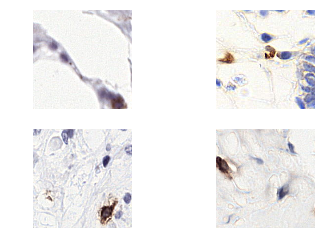

In [12]:
# Define a function to read images from disk and convert them to xyc format in a desire output range.
def load_image(input_path, range_min=0, range_max=1):
    
    # Read image data (x, y, c) [0, 255]
    image = Image.open(input_path)
    
    
    half_the_width = image.size[0] / 2
    half_the_height = image.size[1] / 2
    image = image.crop(
        (
            half_the_width - 100,
            half_the_height - 100,
            half_the_width + 100,
            half_the_height + 100
        )
    )
    
    # Convert image to the correct range
    image = np.asarray(image) / 255

    return image

# Define a function to plot a batch or list of image patches in a grid
def plot_image(images, images_per_row=8):
    
    fig, axs = plt.subplots(int(np.ceil(len(images)/images_per_row)), images_per_row)
    
    c = 0
    for ax_row in axs:
        for ax in ax_row:
            if c < len(images):
                ax.imshow(images[c])
            ax.axis('off')            
            c += 1
    plt.show()
    
training_paths = os.listdir(train_dir)
validation_paths = os.listdir(validation_dir)

training_images = [load_image(join(train_dir, path)) for path in training_paths[:50]]
print('Some training examples (shape {shape}):'.format(shape=training_images[0].shape))
plot_image(training_images[12:16], images_per_row=2)

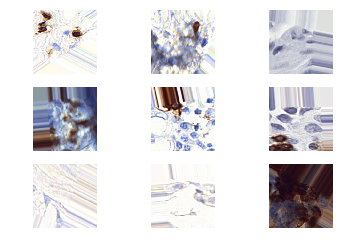

In [13]:
# define data preparation
datagen = ImageDataGenerator(rotation_range=90,
                                     horizontal_flip=True, 
                                     vertical_flip=True, 
                                     zoom_range=0.3, 
                                     width_shift_range=.3, 
                                     height_shift_range=.3)

fake_labels = np.random.rand(len(training_images))
fake_labels[fake_labels >= .5] = 1
fake_labels[fake_labels < .5] = 0

datagen.fit(training_images)

for X_batch, y_batch in datagen.flow(np.array(training_images), fake_labels, batch_size=9):
    plot_image(X_batch, images_per_row=3)
    break

## 1d. Storing and getting patches 
Store everything in these objects to disk.

In [14]:
def storepatchesondisk(patches, dirname):
    #TODO
    print('Patches stored!')

def getpatchesfromdisk():
    #TODO
    return patches

# Part 2 - Networks
This is where things go deep. The following two networks are defined

* A "stardard" U-net that maxes out at 512
* A copy of the U-net used to create a Retina U-net detector. Very specific approach and smaller than the standard u-net

Additionally this section contains the following:
* A method to calculate the f1-score
* A method to save intermediate best networks
* Some sanity checks: side-by-side plot of images and masks
* Generating suitable training images
* Model compilation 
* Model training

### U-net architecture

In [15]:
def get_unet(img_rows=512, img_cols=512, channels=3):
    # A common problem is that Keras might automatically detect "Channels first" or last. The below notation is "Channels last"
    # Which seems to be the default on cartesius. Problem, we only have once channel if we opt to only use the green channel
    #
    # Regarding input layer size - this does not seem to be our problem (Keras docs):
    # When using this layer as the first layer in a model, provide the keyword argument input_shape (tuple of integers,
    # does not include the sample axis), e.g. input_shape=(128, 128, 3) for 128x128 RGB pictures in 
    # data_format="channels_last".
    
    # So flattening also does not force the data into our format (e.g. by using a Flatten() layer)
    
    # Our error seems to be related to https://github.com/keras-team/keras/issues/6351 which includes many miracle fixes
    # yet nothing for us.
    
    inputs = Input(shape=(img_rows, img_cols, channels))
    s = keras.layers.core.Lambda(lambda x: x / 255) (inputs)
    
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(s)
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1)
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2)
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    
    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool3)
    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(pool4)
    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv5)

    up6 = concatenate([Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(conv5), conv4], axis=3)
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(up6)
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv6)

    up7 = concatenate([Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv6), conv3], axis=3)
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(up7)
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv7)

    up8 = concatenate([Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv7), conv2], axis=3)
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(up8)
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv8)

    up9 = concatenate([Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(conv8), conv1], axis=3)
    conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(up9)
    conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv9)
 
    conv10 = Conv2D(3, (1, 1), activation='sigmoid')(conv9)
    model = Model(inputs=inputs, outputs=conv10)
    # we need to punish overfitting on background harshly until our model improves. Dice coef seems to get used often 
    # in literature, and kaggle. Using binary crossentropy for the moment. Before we were using categorical crossentropy
    model.compile(optimizer='SGD', loss='categorical_crossentropy',metrics=['accuracy'])

    return model

In [16]:
def get_secondunet(img_rows=512, img_cols=512, channels=3):
    inputs = Input(shape=(img_rows, img_cols, channels))
    s = keras.layers.core.Lambda(lambda x: x / 255) (inputs)
    # Unet taken fromDaniele Cortinovis Retina-net https://github.com/orobix/retina-unet
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same',data_format='channels_first')(s)
    conv1 = Dropout(0.2)(conv1)
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same',data_format='channels_first')(conv1)
    pool1 = MaxPooling2D((2, 2))(conv1)
    #
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same',data_format='channels_first')(pool1)
    conv2 = Dropout(0.2)(conv2)
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same',data_format='channels_first')(conv2)
    pool2 = MaxPooling2D((2, 2))(conv2)
    #
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same',data_format='channels_first')(pool2)
    conv3 = Dropout(0.2)(conv3)
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same',data_format='channels_first')(conv3)

    up1 = UpSampling2D(size=(2, 2))(conv3)
    up1 = concatenate([conv2,up1],axis=1)
    conv4 = Conv2D(64, (3, 3), activation='relu', padding='same',data_format='channels_first')(up1)
    conv4 = Dropout(0.2)(conv4)
    conv4 = Conv2D(64, (3, 3), activation='relu', padding='same',data_format='channels_first')(conv4)
    #
    up2 = UpSampling2D(size=(2, 2))(conv4)
    up2 = concatenate([conv1,up2], axis=1)
    conv5 = Conv2D(32, (3, 3), activation='relu', padding='same',data_format='channels_first')(up2)
    conv5 = Dropout(0.2)(conv5)
    conv5 = Conv2D(32, (3, 3), activation='relu', padding='same',data_format='channels_first')(conv5)
    #
    conv6 = Conv2D(2, (1, 1), activation='relu',padding='same',data_format='channels_first')(conv5)
    conv6 = core.Reshape((2,img_rows*img_cols))(conv6) 
    conv6 = core.Permute((2,1))(conv6)
    ############
    conv7 = core.Activation('softmax')(conv6)

    model = Model(inputs=inputs, outputs=conv7)

    # sgd = SGD(lr=0.01, decay=1e-6, momentum=0.3, nesterov=False)
    model.compile(optimizer='sgd', loss='categorical_crossentropy',metrics=['accuracy'])

    return model

Network parameters, from Francesco's paper:

* LR = 0.05
* Dropouts 0.5 (when?)
* SGD
* CCR (cross-entropy) loss
* F1-score

* RGB threshold on training imgs

Also 10 epochs with batch size 1. x20 resolution and 128x128 in- and output size 


In [17]:
def f1_score(y_true, y_pred):
    # Compute precision, recall and obtain several detection thresholds
    precision, recall, thresholds = precision_recall_curve(y_true, y_pred)
    
    # Compute F1-score and remove numerical problems
    f1 =  2 * (precision * recall) / (precision + recall)
    f1 = f1[~np.isnan(f1)]
    
    return f1

(300, 512, 512, 3)
(300, 512, 512, 3)


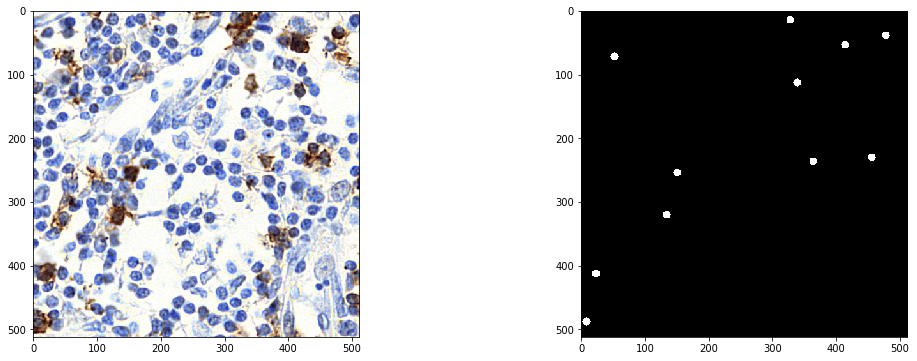

In [18]:
print(np.asarray(img_patches).shape) #should be (512, 512, 3)
print(np.asarray(mask_patches).shape)
y_train = np.asarray(mask_patches)
y_train = y_train[:,:,:,1]
#y_train = y_train.reshape((-1, 1))
ino = 7

plt.figure(1, figsize=(18, 6))
# for the record, matplotlib uses this short-hand notation to show subplots. The 121 here stands for 1 row, 2 columns, first img
# now you know how to use subplots like a pro.
plt.subplot(121)
plt.imshow(img_patches[ino])

plt.subplot(122)
plt.imshow(mask_patches[ino])

In [19]:
model = get_unet(512, 512, num_channels)
model_checkpoint = ModelCheckpoint('weights.h5', monitor='val_loss', save_best_only=True)
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 512, 512, 3)  0                                            
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, 512, 512, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 512, 512, 32) 896         lambda_1[0][0]                   
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 512, 512, 32) 9248        conv2d_1[0][0]                   
__________________________________________________________________________________________________
max_poolin

In [20]:
X_train = []
y_train = []
for img in img_patches:
    X_train.append(np.asarray(img[:, :, :]))
for msk in mask_patches:
    y_train.append(np.asarray(msk[:, :, :]))

#sanity checks.. what sizes are we dealing with?
print(len(X_train))
print(np.shape(X_train))
print(np.shape(y_train))

300
(300, 512, 512, 3)
(300, 512, 512, 3)


In [21]:
# One epoch generally takes 1 minute with batch size 1, 200 samples. Something to keep in mind..
# the issues with 
# model.fit_generator(imgs_train, imgs_mask_train, batch_size=1, nb_epoch=10, verbose=1, shuffle=True, validation_split=0.2, callbacks=[model_checkpoint])
model.fit(np.asarray(X_train), np.asarray(y_train), batch_size=1, epochs=3, verbose=1, shuffle=True, validation_split=0.2, callbacks=[model_checkpoint])

Train on 240 samples, validate on 60 samples
Epoch 1/3
240/240 [==============================] - 88s 366ms/step - loss: 2.2794 - acc: 0.9716 - val_loss: 3.3412 - val_acc: 0.9480
Epoch 2/3
240/240 [==============================] - 82s 343ms/step - loss: 2.2793 - acc: 0.9583 - val_loss: 3.3412 - val_acc: 0.9332
Epoch 3/3
240/240 [==============================] - 82s 343ms/step - loss: 2.2793 - acc: 0.9481 - val_loss: 3.3412 - val_acc: 0.9283


# Part 3 - Using the Validation set for a sanity check
The below code does the following things:

* Load the best-yet model 

* load the validation images we've been supplied with
* Generate masks for the validation images
    * Creates a validation_masks_dir if there is none yet.
    * Creates validation masks or loads them
    * Creates patches for the validation set
* Show side-by-side plots of the original validation image and the new mask

* Shove one image in our best model and ask predict() what it makes out of it
    * apply a threshold to the image
* Plot the orgininal image, the defined mask, and the prediction side-by-side

In [22]:
# load our best model
model1 = keras.models.load_model('weights.h5') #saved by our callback earlier

In [23]:
# if it does not exist already, create the validation masks folder
validation_paths = os.listdir(validation_dir)
if os.path.exists(validation_masks_dir):
    pass
else:
    os.system('mkdir -p ' + validation_masks_dir)

# generate the masks if they are not already present on the system.
mask_paths = os.listdir(validation_masks_dir)
for path in validation_paths:
    mask_name = path.split('.png')[0] + '_mask.png'
    if mask_name not in mask_paths:
        createMaskForImage(validation_dir, path, validation_points, validation_masks_dir, createCircularMask)

Processing 1079_CD3_ROI_8
Created a mask for: 1079_CD3_ROI_8
Processing T17-071840_III5_CD3_ROI_12
Created a mask for: T17-071840_III5_CD3_ROI_12
Processing T17-071827_III6_CD-8_ROI_4
Created a mask for: T17-071827_III6_CD-8_ROI_4
Processing T17-071827_III6_CD-8_ROI_9
Created a mask for: T17-071827_III6_CD-8_ROI_9
Processing 27_CD3_ROI_7
Created a mask for: 27_CD3_ROI_7
Processing 23-CD8_ROI_4
Created a mask for: 23-CD8_ROI_4
Processing 96-20259-E1_CD8_ROI_13
Created a mask for: 96-20259-E1_CD8_ROI_13
Processing 27_CD3_ROI_3
Created a mask for: 27_CD3_ROI_3
Processing T17-071840_III5_CD3_ROI_6
Created a mask for: T17-071840_III5_CD3_ROI_6
Processing 23-CD8_ROI_8
Created a mask for: 23-CD8_ROI_8
Processing T17-071840_III5_CD3_ROI_11
Created a mask for: T17-071840_III5_CD3_ROI_11
Processing 96-20259-E1_CD8_ROI_4
Created a mask for: 96-20259-E1_CD8_ROI_4
Processing T17-071827_III6_CD-8_ROI_3
Created a mask for: T17-071827_III6_CD-8_ROI_3
Processing 96-20259-E1_CD8_ROI_12
Created a mask fo

In [24]:
vpatches = generate_patches(validation_dir, validation_masks_dir, 20, 512, 512)
vmask_patches = []
vimg_patches = []
for patch in vpatches:
    vimg_patches.append(np.array(patch[0]))
    vmask_patches.append(np.array(patch[1]))

/hpc/sw/python-3.5.2/lib/python3.5/site-packages/ipykernel_launcher.py:10: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0.
Use ``matplotlib.pyplot.imread`` instead.
  # Remove the CWD from sys.path while we load stuff.
/hpc/sw/python-3.5.2/lib/python3.5/site-packages/ipykernel_launcher.py:11: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0.
Use ``matplotlib.pyplot.imread`` instead.
  # This is added back by InteractiveShellApp.init_path()


1: (512, 512, 3)  image: T17-071840_III5_CD3_ROI_8_mask.png
1: (512, 512, 3)  mask:  T17-071840_III5_CD3_ROI_8.png
2: (512, 512, 3)  image: 23-CD8_ROI_12_mask.png
2: (512, 512, 3)  mask:  23-CD8_ROI_12.png
3: (512, 512, 3)  image: 27_CD3_ROI_4_mask.png
3: (512, 512, 3)  mask:  27_CD3_ROI_4.png
4: (512, 512, 3)  image: 27_CD3_ROI_11_mask.png
4: (512, 512, 3)  mask:  27_CD3_ROI_11.png
padding: 264x0
5: (512, 512, 3)  image: 1079_CD3_ROI_12_mask.png
5: (512, 512, 3)  mask:  1079_CD3_ROI_12.png
6: (512, 512, 3)  image: 96-20259-E1_CD8_ROI_11_mask.png
6: (512, 512, 3)  mask:  96-20259-E1_CD8_ROI_11.png
7: (512, 512, 3)  image: T17-071840_III5_CD3_ROI_11_mask.png
7: (512, 512, 3)  mask:  T17-071840_III5_CD3_ROI_11.png
8: (512, 512, 3)  image: 23-CD8_ROI_9_mask.png
8: (512, 512, 3)  mask:  23-CD8_ROI_9.png
9: (512, 512, 3)  image: 23-CD8_ROI_7_mask.png
9: (512, 512, 3)  mask:  23-CD8_ROI_7.png
10: (512, 512, 3)  image: T17-071840_III5_CD3_ROI_9_mask.png
10: (512, 512, 3)  mask:  T17-071840_II

In [25]:
val_images_p = []
for img in vimg_patches:
    val_images_p.append(np.asarray(img[:, :, :]))
    
#sanity checks.. what sizes are we dealing with?
print(len(val_images_p))
print(np.shape(val_images_p))

20
(20, 512, 512, 3)


(512, 512, 3)


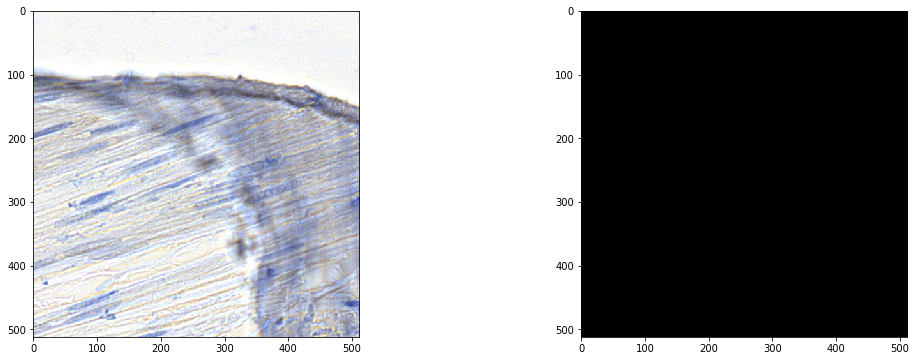

In [26]:
#show validation image and it's mask - Another sanity check
plt.figure(1, figsize=(18, 6))

plt.subplot(121)
print(vimg_patches[0].shape)
plt.imshow(vimg_patches[1])

plt.subplot(122)
plt.imshow(vmask_patches[1])

In [27]:
# Make some predictions
preds_val = model1.predict(np.asarray(val_images_p), verbose=1)

20/20 [==============================] - 7s 340ms/step


In [28]:
# threshold prediction
preds_val_t = (preds_val > 0.5).astype(np.uint8)

In [29]:
#sanity check for checking image size
print(np.shape(vimg_patches[0]))
print(np.shape(preds_val[0])) 
print(np.shape(preds_val_t[0]))

(512, 512, 3)
(512, 512, 3)
(512, 512, 3)


(512, 512, 3)
(512, 512, 3)


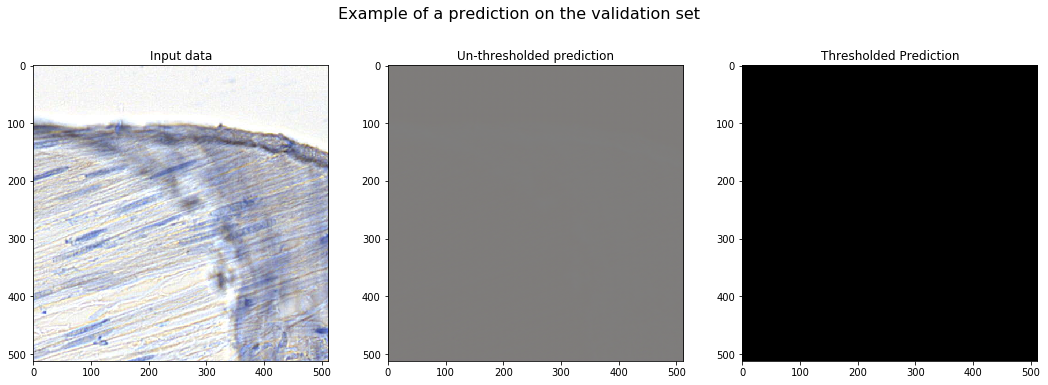

In [30]:
# create a subplot of 1 row
plt.figure(1, figsize=(18, 6))
plt.suptitle('Example of a prediction on the validation set', fontsize=16)

idx = 1 

# plot original image
plt.subplot(131)
print(vimg_patches[idx].shape)
plt.imshow(vimg_patches[idx])
plt.title('Input data')

#plot raw, unthresholded prediction
plt.subplot(132)
print(preds_val[idx].shape)
plt.imshow(preds_val[idx])
plt.title('Un-thresholded prediction')

#plot thresholded prediction
plt.subplot(133)
plt.imshow(preds_val_t[idx])
plt.title('Thresholded Prediction')

In [31]:
print(preds_val_t[idx])

[[[0 0 0]
  [0 0 0]
  [0 1 0]
  ..., 
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[1 0 0]
  [0 0 0]
  [1 1 0]
  ..., 
  [1 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 1 0]
  ..., 
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 ..., 
 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ..., 
  [1 0 0]
  [1 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ..., 
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ..., 
  [0 0 0]
  [1 0 0]
  [0 0 0]]]


In [32]:
# Run it over the entire test set, now..
# TODO

In [33]:
# make dir for results
result_dir = 'Results'
# Create directory for the results (if not already existing)
if os.path.exists(result_dir):
    pass
else:
    os.system('mkdir -p ' + result_dir)

In [34]:
# store image results to the results folder
# TODO once these turn into actual images

# Part 4 - Evaluation on the test set

This part will have the following bits:
* loading test imags
* Predicting on the test set
* Calculating the center point of each annotation
* Writing these to a csv file to prepare a submission.

# Part 5 - What is outside the flow of work
Counting the number of lymphocytes was the goal of the project although the evaluation is based on the precision of the network. Therefore the following method returns the number of lymphocytes, given a sample image. 

In [31]:
# function to count the number of lymphocytes in a given image
# TODO
def count_lymps(image):
    count = 0
    return count

In [32]:
# and other things that come up